In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# 日本語フォントの指定
mpl.rcParams['font.family'] = 'IPAexGothic' # ここにインストールしたフォント名を入れる

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [3]:
train = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/train_feature_ver2.csv')
test = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/test_feature_ver2.csv')
era = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/era.csv')
sample_submission = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/sample_submission.csv')

In [4]:
test.head()

,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,...,502,503,504,505,506,507,508,509,510,511
0,NaN,工芸品,日本,江戸,京都府（京都府）,NaN,NaN,相国寺,NaN,NaN,...,-0.025584,-0.012252,-0.012271,0.072874,-0.039801,-0.021271,0.012467,0.034596,-0.023817,-0.030492
1,NaN,絵画,日本,平安,和歌山県（和歌山県）,NaN,NaN,西禅院,財団法人高野山文化財保存会,NaN,...,-0.026519,-0.036004,-0.035254,0.027655,0.045121,-0.018657,0.041083,0.062436,-0.019814,-0.036495
2,NaN,絵画,日本,平安,東京都（東京都）,東京都世田谷区上野毛3-9-25,公益財団法人五島美術館,東急株式会社,NaN,35.612290,...,0.032094,-0.013380,-0.010027,0.061131,-0.004584,-0.046228,0.044919,0.028419,-0.051641,-0.015564
3,NaN,近世以前／神社,NaN,江戸前期,和歌山県,和歌山県有田郡広川町大字上中野,NaN,廣八幡宮,NaN,34.017835,...,-0.025453,-0.023700,0.009060,0.075206,0.018822,-0.062776,0.016009,-0.022042,-0.035110,-0.050560
4,NaN,彫刻,日本,平安,山形県（山形県）,NaN,NaN,吉祥院,NaN,NaN,...,-0.037568,-0.031847,-0.014172,0.075822,0.017364,-0.073429,-0.018416,0.025913,0.005010,-0.012969


In [5]:
#categorical変数抽出
cat_cols = [c for c in test.columns if train[c].dtype == np.object]
cat_cols.remove('string') # これは取り除かないといけない

# numerical変数抽出
num_cols = [c for c in test.columns if train[c].dtype != np.object]

#目的変数抽出
target_col = 'is_kokuhou'

print(cat_cols)
print(num_cols)
print(target_col)

['棟名', '種別2', '国', '時代', '都道府県 ※美工品は「所有者住所（所在都道府県）」', '所在地', '保管施設の名称', '所有者名', '管理団体又は責任者']
['緯度', '経度', '開始', '終了', '緯度*経度', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [6]:
# target encoding

# kf = KFold(4)
# kf = KFold(4, groups=train.categorical)　#GroupKFold
kf = StratifiedKFold(5, shuffle=True, random_state=42531) #StratifiedKFold

# Target encoding with K-fold
# te = TargetEncoder(kf.split(train))
# te = TargetEncoder(kf.split(train)) #GroupKFold
te = TargetEncoder(kf.split(train, train[target_col])) #StratifiedKFold

# use fit/fit_transform to train data, then apply transform to test data
train.loc[:, cat_cols] = te.fit_transform(train[cat_cols], train[target_col])
test.loc[:, cat_cols] = te.transform(test[cat_cols])

In [7]:
print(len(cat_cols) + len(num_cols))

526


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[1]	valid_0's binary_logloss: 0.260879
[2]	valid_0's binary_logloss: 0.257172
[3]	valid_0's binary_logloss: 0.254803
[4]	valid_0's binary_logloss: 0.252655
[5]	valid_0's binary_logloss: 0.250033
[6]	valid_0's binary_logloss: 0.248346
[7]	valid_0's binary_logloss: 0.248833
[8]	valid_0's binary_logloss: 0.247228
[9]	valid_0's binary_logloss: 0.273668
[10]	valid_0's binary_logloss: 0.270442
[11]	valid_0's binary_logloss: 0.267258
[12]	valid_0's binary_logloss: 0.267258
[13]	valid_0's binary_logloss: 0.267522
[14]	valid_0's binary_logloss: 0.264894
[15]	valid_0's binary_logloss: 0.261891
[16]	valid_0's binary_logloss: 0.25959
[17]	valid_0's binary_logloss: 0.257334
[18]	valid_0's binary_logloss: 0.255202
[19]	valid_0's binary_logloss: 0.29775
[20]	valid_0's binary_logloss: 0.292424
[21]	valid_0's binary_logloss: 0.293366
[22]	valid_0's binary_logloss: 0.288866
[23]	valid_0's binary_l

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	valid_0's binary_logloss: 0.260793
[2]	valid_0's binary_logloss: 0.258224
[3]	valid_0's binary_logloss: 0.25348
[4]	valid_0's binary_logloss: 0.250402
[5]	valid_0's binary_logloss: 0.24834
[6]	valid_0's binary_logloss: 0.24716
[7]	valid_0's binary_logloss: 0.247156
[8]	valid_0's binary_logloss: 0.245646
[9]	valid_0's binary_logloss: 0.276042
[10]	valid_0's binary_logloss: 0.273076
[11]	valid_0's binary_logloss: 0.270365
[12]	valid_0's binary_logloss: 0.270365
[13]	valid_0's binary_logloss: 0.270376
[14]	valid_0's binary_logloss: 0.267895
[15]	valid_0's binary_logloss: 0.265172
[16]	valid_0's binary_logloss: 0.262554
[17]	valid_0's binary_logloss: 0.259848
[18]	valid_0's binary_logloss: 0.257358
[19]	valid_0's binary_logloss: 0.304097
[20]	valid_0's binary_logloss: 0.299314
[21]	valid_0's binary_logloss: 0.300408
[22]	valid_0's binary_logloss: 0.295543
[23]	valid_0's binary_logloss: 0.290774
[24]	valid_0's binary_logloss: 0.290224
[25]	valid_0's binary_logloss: 0.28603
[26]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	valid_0's binary_logloss: 0.259138
[2]	valid_0's binary_logloss: 0.253874
[3]	valid_0's binary_logloss: 0.249459
[4]	valid_0's binary_logloss: 0.245486
[5]	valid_0's binary_logloss: 0.242815
[6]	valid_0's binary_logloss: 0.240288
[7]	valid_0's binary_logloss: 0.240492
[8]	valid_0's binary_logloss: 0.237953
[9]	valid_0's binary_logloss: 0.269802
[10]	valid_0's binary_logloss: 0.266401
[11]	valid_0's binary_logloss: 0.262789
[12]	valid_0's binary_logloss: 0.262789
[13]	valid_0's binary_logloss: 0.262909
[14]	valid_0's binary_logloss: 0.259727
[15]	valid_0's binary_logloss: 0.256602
[16]	valid_0's binary_logloss: 0.254045
[17]	valid_0's binary_logloss: 0.251365
[18]	valid_0's binary_logloss: 0.248666
[19]	valid_0's binary_logloss: 0.295663
[20]	valid_0's binary_logloss: 0.290121
[21]	valid_0's binary_logloss: 0.291148
[22]	valid_0's binary_logloss: 0.285684
[23]	valid_0's binary_logloss: 0.280513
[24]	valid_0's binary_logloss: 0.280256
[25]	valid_0's binary_logloss: 0.275701
[26]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[1]	valid_0's binary_logloss: 0.26177
[2]	valid_0's binary_logloss: 0.256534
[3]	valid_0's binary_logloss: 0.252649
[4]	valid_0's binary_logloss: 0.248768
[5]	valid_0's binary_logloss: 0.2466
[6]	valid_0's binary_logloss: 0.244405
[7]	valid_0's binary_logloss: 0.244033
[8]	valid_0's binary_logloss: 0.241682
[9]	valid_0's binary_logloss: 0.271632
[10]	valid_0's binary_logloss: 0.268717
[11]	valid_0's binary_logloss: 0.265679
[12]	valid_0's binary_logloss: 0.265679
[13]	valid_0's binary_logloss: 0.266125
[14]	valid_0's binary_logloss: 0.263081
[15]	valid_0's binary_logloss: 0.260439
[16]	valid_0's binary_logloss: 0.258006
[17]	valid_0's binary_logloss: 0.255124
[18]	valid_0's binary_logloss: 0.252579
[19]	valid_0's binary_logloss: 0.30074
[20]	valid_0's binary_logloss: 0.296153
[21]	valid_0's binary_logloss: 0.297147
[22]	valid_0's binary_logloss: 0.291834
[23]	valid_0's binary_log

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1]	valid_0's binary_logloss: 0.260209
[2]	valid_0's binary_logloss: 0.254772
[3]	valid_0's binary_logloss: 0.248614
[4]	valid_0's binary_logloss: 0.244543
[5]	valid_0's binary_logloss: 0.242036
[6]	valid_0's binary_logloss: 0.23964
[7]	valid_0's binary_logloss: 0.239311
[8]	valid_0's binary_logloss: 0.236665
[9]	valid_0's binary_logloss: 0.267668
[10]	valid_0's binary_logloss: 0.264278
[11]	valid_0's binary_logloss: 0.260139
[12]	valid_0's binary_logloss: 0.260139
[13]	valid_0's binary_logloss: 0.260817
[14]	valid_0's binary_logloss: 0.257189
[15]	valid_0's binary_logloss: 0.253845
[16]	valid_0's binary_logloss: 0.25092
[17]	valid_0's binary_logloss: 0.247847
[18]	valid_0's binary_logloss: 0.245535
[19]	valid_0's binary_logloss: 0.292953
[20]	valid_0's binary_logloss: 0.287404
[21]	valid_0's binary_logloss: 0.288508
[22]	valid_0's binary_logloss: 0.282809
[23]	valid_0's binary_logloss: 0.277564
[24]	valid_0's binary_logloss: 0.277476
[25]	valid_0's binary_logloss: 0.2726
[26]	valid_0'

/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 2

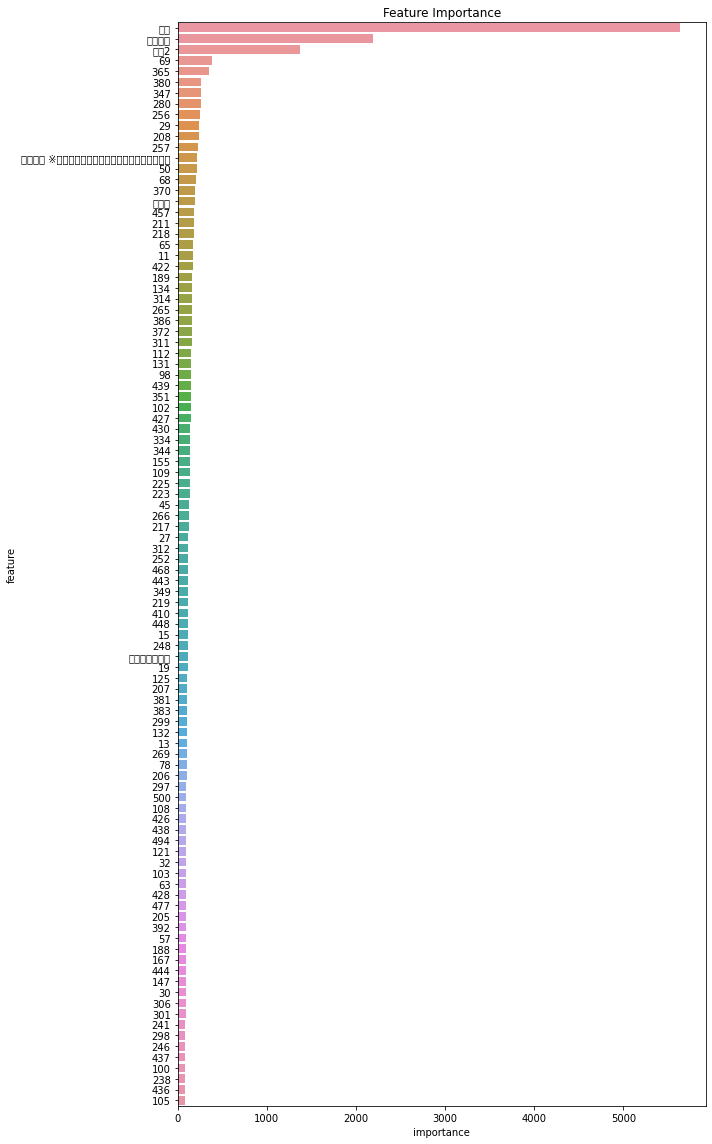

In [8]:
params = {
    'boosting': "dart", # dart, gbdt, goss, rf
    'objective': "binary", # binary, multiclass, regression
    'metric': "binary_logloss", # mae, mse, auc, binary_logloss, multi_logloss, rmse, average_precision
    'learning_rate':0.05, #0.05
    'n_estimators': 210,
    'max_depth': -1,
    'random_state' : 42531
    #'num_leaves' : 100, #カーディナリティが高い場合は大きくする
    #'max_bin' : 500,
}

result = run_experiment(params,
                        train[num_cols + cat_cols],
                        train[target_col],
                        test[num_cols + cat_cols],
                        cv=StratifiedKFold(5, shuffle=True, random_state=42531), #cv=5,
                        #groups=train.group
                        )

In [10]:
print(result.metrics) # Evalulation metrics for each fold

[0.7830434782608695, 0.7822745571658616, 0.8266908212560387, 0.8261433172302737, 0.8351138095276086, 0.8096638097616974]


In [9]:
print(result.metrics) # Evalulation metrics for each fold

[0.7725885668276973, 0.7818236714975845, 0.8162882447665056, 0.817194041867955, 0.8370046513112228, 0.8053098184368901]


In [11]:
result.importance     # Feature importance for each fold

[                       feature   importance
 0                           緯度     0.000000
 1                           経度    54.881151
 2                           開始    61.914459
 3                           終了     9.809250
 4                        緯度*経度     4.011090
 ..                         ...          ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」   139.928192
 522                        所在地   218.200899
 523                    保管施設の名称    81.391920
 524                       所有者名  2778.252915
 525                  管理団体又は責任者    14.804530
 
 [526 rows x 2 columns],
                        feature   importance
 0                           緯度    15.142149
 1                           経度    14.875710
 2                           開始     0.000000
 3                           終了     0.000000
 4                        緯度*経度     4.200130
 ..                         ...          ...
 521  都道府県 ※美工品は「所有者住所（所在都道府県）」   264.755912
 522                        所在地   225.828590
 523                    保管施設

In [9]:
print(result.test_prediction)  # Test prediction in numpy array
print(result.oof_prediction)   # Out-of-fold prediction in numpy array

[0.01720011 0.23343002 0.3879861  ... 0.15503867 0.02177689 0.01802679]
[0.01047598 0.11601828 0.51602494 ... 0.10156271 0.19104504 0.01989442]


In [10]:
train[target_col].to_numpy()

array([0, 0, 1, ..., 0, 0, 0])

In [11]:
# データ全体のF1スコアを計算 & 閾値の最適化
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        score = f1_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# 例として使用するデータ（実際にはモデルからの予測値と実際のラベルを使用）
y_true = train[target_col].values
y_scores = result.oof_prediction

best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best threshold: 0.19191919191919193
Best F1 Score: 0.35726795096322245


In [12]:
# 閾値を超える確率を持つ要素を1に、それ以外を0に変換
y_pred = (result.test_prediction > best_threshold).astype(int)
print(y_pred)
print(y_pred.shape)

[0 1 1 ... 0 0 0]
(10065,)


In [14]:
sample_submission['is_kokuhou'] = y_pred
sample_submission

,is_kokuhou
0,0
1,1
2,1
3,0
4,0
...,...
10060,0
10061,0
10062,0
10063,0


In [15]:
sample_submission["is_kokuhou"].value_counts()

0    9079
1     986
Name: is_kokuhou, dtype: int64

In [18]:
sample_submission.to_csv('lightgbm_ver4.csv', index=False)

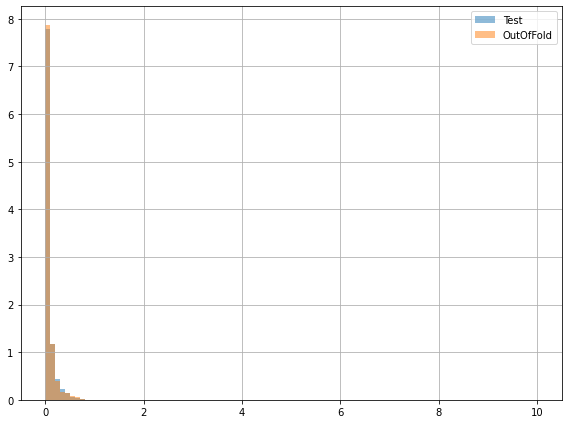

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(result.test_prediction, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(result.oof_prediction, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [17]:
print(result.test_prediction)
print(result.oof_prediction)

[0.01720011 0.23343002 0.3879861  ... 0.15503867 0.02177689 0.01802679]
[0.01047598 0.11601828 0.51602494 ... 0.10156271 0.19104504 0.01989442]


In [18]:
df_oof = pd.DataFrame({'lgb_ver4_oof':result.oof_prediction})
df_test = pd.DataFrame({'lgb_ver4_test' : result.test_prediction})

In [19]:
print(df_oof.shape)
print(df_test.shape)

(6710, 1)
(10065, 1)


In [20]:
df_oof.to_csv('lgb_ver4_oof.csv', index=False)
df_test.to_csv('lgb_ver4_test.csv', index=False)